In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
# Displaying first few rows
print("Train DataFrame head:")
print(train_df.head())
print("\nTest DataFrame Head:")
print(test_df.head())

#Display basic info and missing values
print("\nTrain DataFrame Info:")
train_df.info()
print("\nTrain DataFrame Missing Values (Top 20):")
print(train_df.isnull().sum().sort_values(ascending=False).head(20))

Train DataFrame head:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  

In [4]:
# For columns where NaN implies 'None' or 'No', fill with 'None' string
for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSZoning', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Electrical', 'Functional', 'SaleType']:
    train_df[col] = train_df[col].fillna('None')
    test_df[col] = test_df[col].fillna('None')

# For remaining numerical missing values, fill with 0 or median/mean
# A quick check might show 'LotFrontage' and 'GarageYrBlt' as numerical with NaNs
for col in ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']:
    train_df[col] = train_df[col].fillna(0) # Or train_df[col].median()
    test_df[col] = test_df[col].fillna(0) # Or test_df[col].median()

# Check again for any remaining missing values (should be very few if any now)
print("\nMissing values after basic imputation (Train):")
print(train_df.isnull().sum().sort_values(ascending=False).head())
print("\nMissing values after basic imputation (Test):")
print(test_df.isnull().sum().sort_values(ascending=False).head())


Missing values after basic imputation (Train):
Id             0
MSSubClass     0
MSZoning       0
LotFrontage    0
LotArea        0
dtype: int64

Missing values after basic imputation (Test):
Utilities       2
BsmtFullBath    2
BsmtHalfBath    2
GarageArea      1
TotalBsmtSF     1
dtype: int64


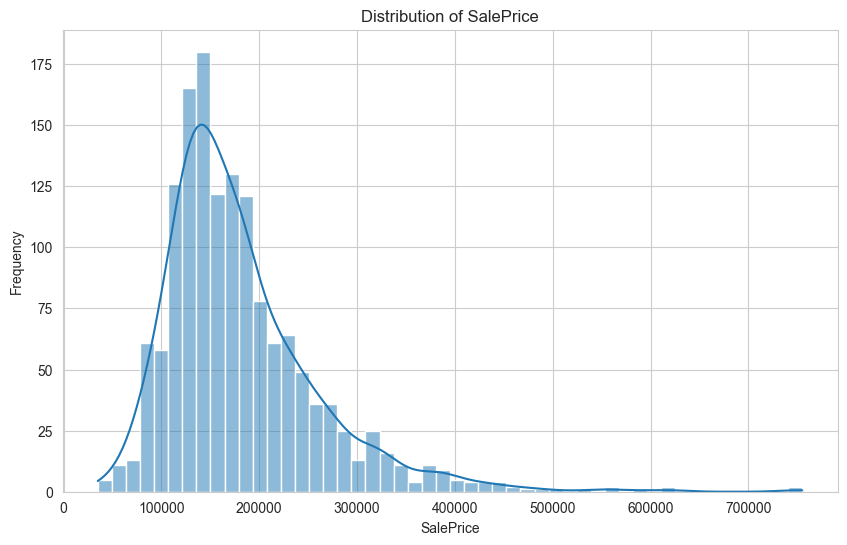

Skewness of SalePrice: 1.8828757597682129
Kurtosis of SalePrice: 6.536281860064529


In [5]:
# Set style for plots
sns.set_style("whitegrid")

# Plot distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice'], kde=True, bins=50)
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.show()

# Check for skewness (a measure of asymmetry of the probability distribution)
print("Skewness of SalePrice:", train_df['SalePrice'].skew())
print("Kurtosis of SalePrice:", train_df['SalePrice'].kurt())



Correlation with SalePrice (Top 10 positive & negative):
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
Name: SalePrice, dtype: float64
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


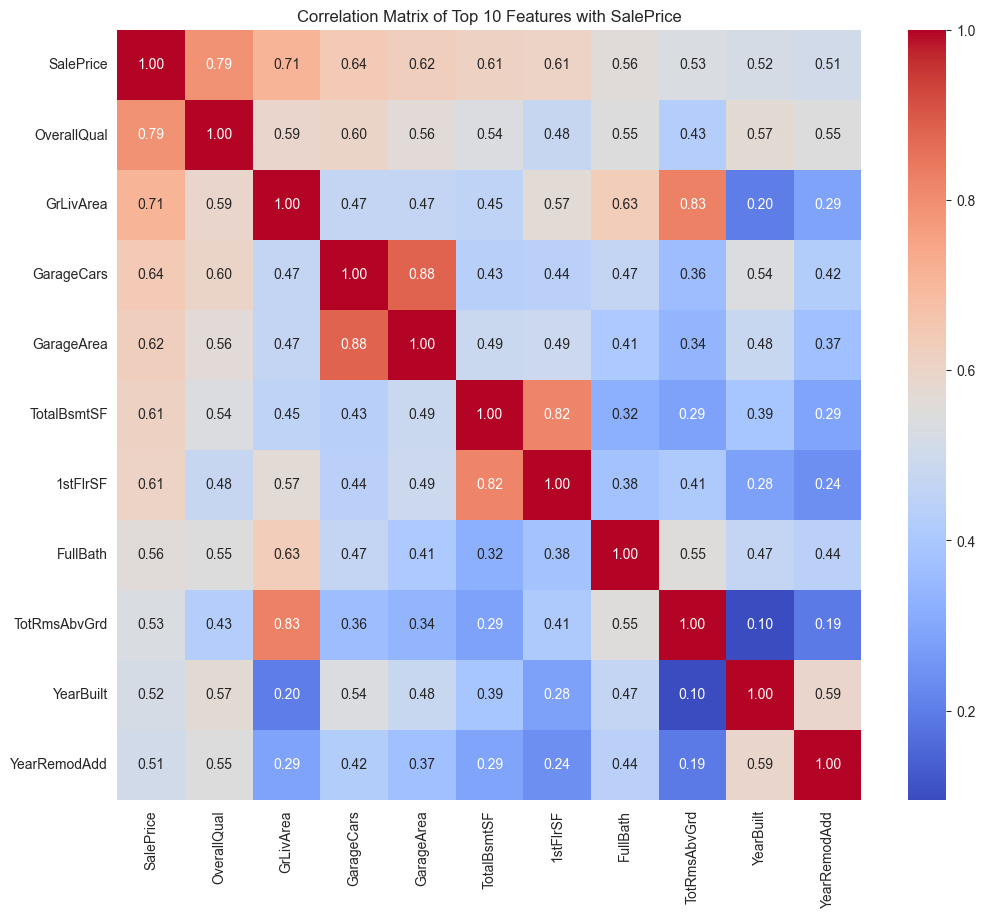

In [6]:
# Select only numerical columns for correlation matrix
numerical_cols = train_df.select_dtypes(include=np.number).columns
corr_matrix = train_df[numerical_cols].corr()

# Sort correlations with SalePrice
saleprice_corr = corr_matrix['SalePrice'].sort_values(ascending=False)
print("\nCorrelation with SalePrice (Top 10 positive & negative):")
print(saleprice_corr.head(11)) # Top 10 positive + SalePrice itself
print(saleprice_corr.tail(10)) # Top 10 negative

# Plot heatmap of top correlated features
top_corr_features = saleprice_corr.head(11).index.tolist()
plt.figure(figsize=(12, 10))
sns.heatmap(train_df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Top 10 Features with SalePrice')
plt.show()

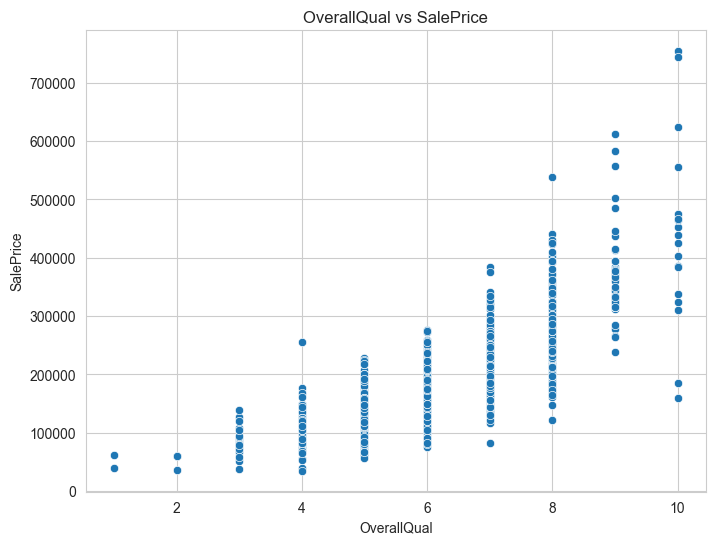

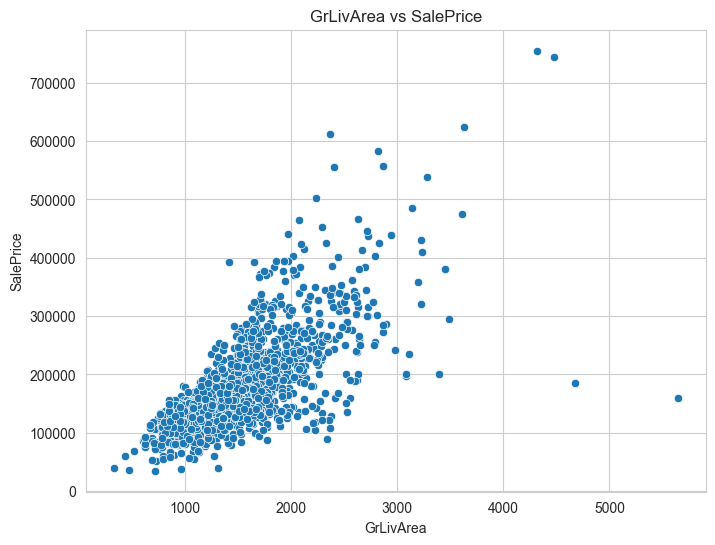

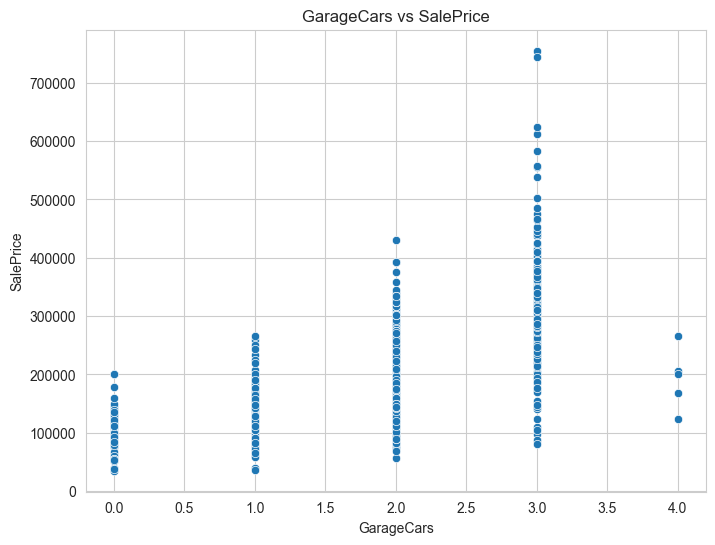

In [7]:
#Scatter plot for OverallQual vs SalePrice
plt.figure(figsize=(8,6))
sns.scatterplot(x='OverallQual', y='SalePrice',data=train_df)
plt.title('OverallQual vs SalePrice')
plt.show()

#Scatter plot for GrLivArea vs SalePrice (Gross living area)
plt.figure(figsize=(8,6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_df)
plt.title('GrLivArea vs SalePrice')
plt.show()

#Scatter plot for GarageCars vs SalePrice
plt.figure(figsize=(8,6))
sns.scatterplot(x='GarageCars',y='SalePrice',data=train_df)
plt.title('GarageCars vs SalePrice')
plt.show()

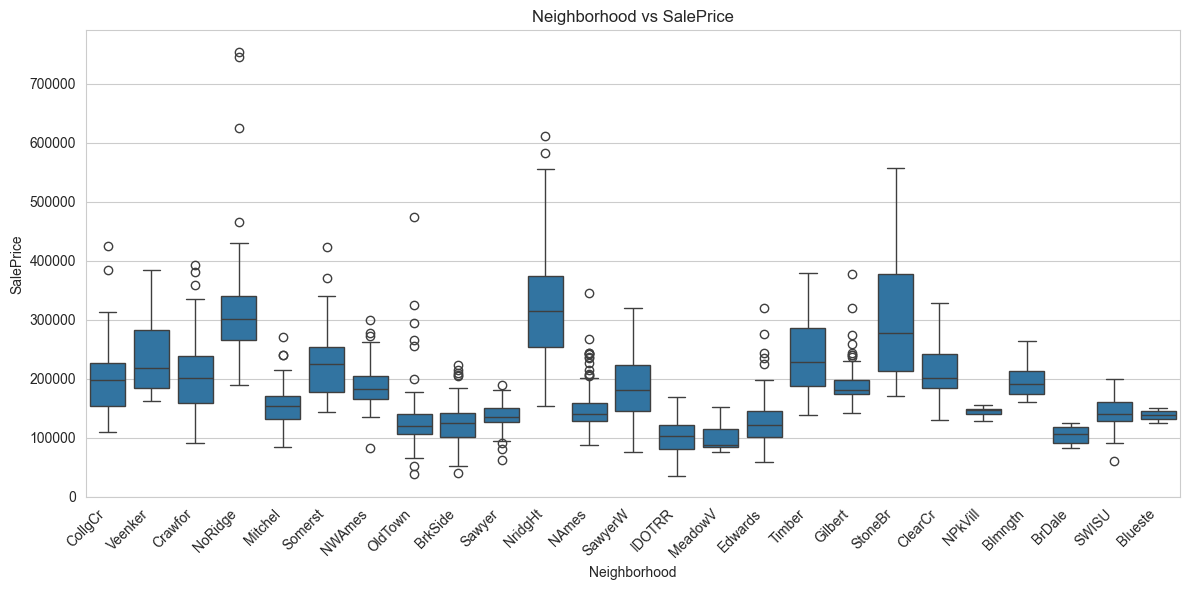

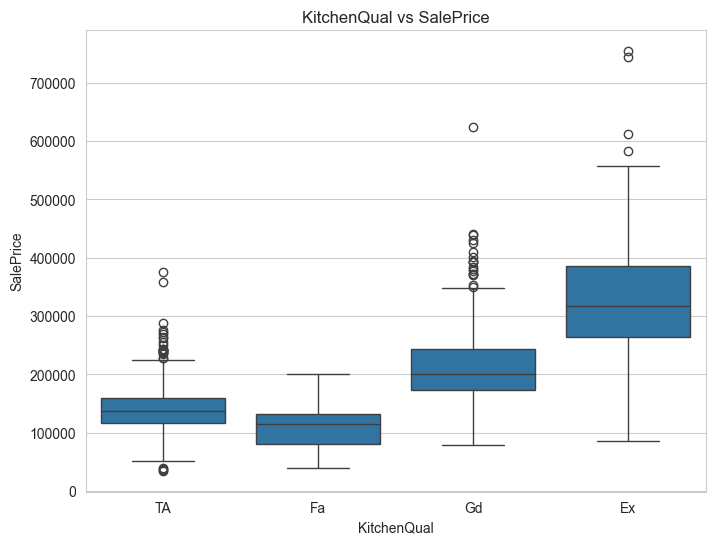

In [8]:
#Box plot for Neighborhood vs SalePrice
plt.figure(figsize=(12,6))
sns.boxplot(x='Neighborhood',y='SalePrice', data=train_df)
plt.title('Neighborhood vs SalePrice')
plt.xticks(rotation=45,ha='right') # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

#Box plot for KitchenQual vs SalePrice
plt.figure(figsize=(8,6))
sns.boxplot(x='KitchenQual',y='SalePrice', data=train_df.sort_values('SalePrice'))
plt.title('KitchenQual vs SalePrice')
plt.show()


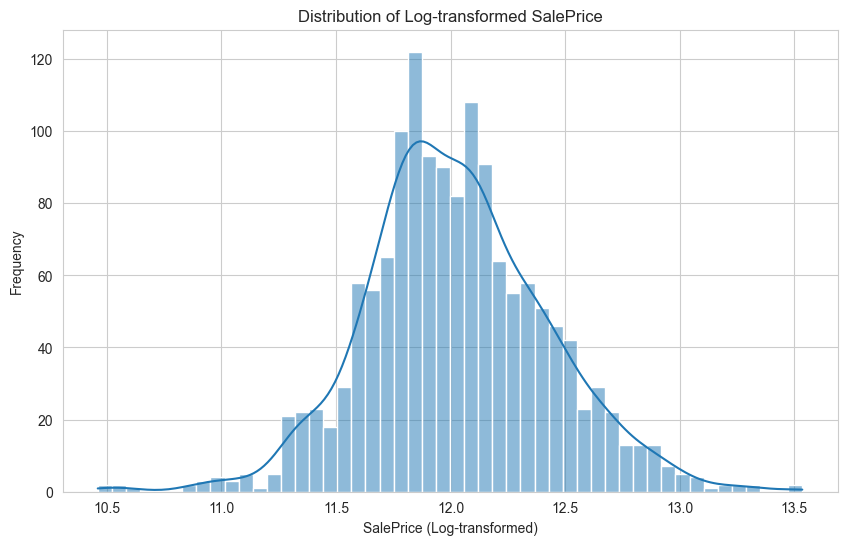

Skewness of Log-transformed SalePrice: 0.12134661989685333


In [9]:
# Apply log1p transformation to SalePrice (target variable)
train_df['SalePrice_Log'] = np.log1p(train_df['SalePrice'])

# Plot the new distribution to see if it's more normal
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice_Log'], kde=True, bins=50)
plt.title('Distribution of Log-transformed SalePrice')
plt.xlabel('SalePrice (Log-transformed)')
plt.ylabel('Frequency')
plt.show()

print("Skewness of Log-transformed SalePrice:", train_df['SalePrice_Log'].skew())

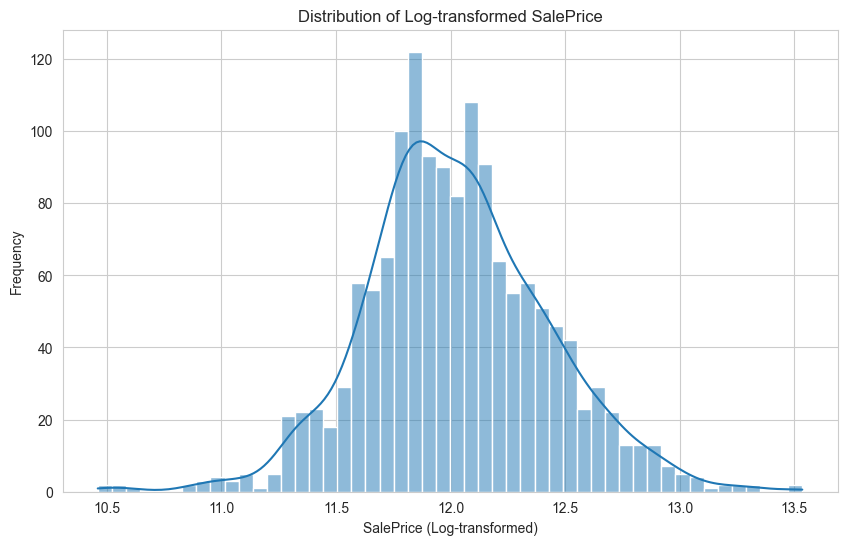

Skewness of Log-transformed SalePrice: 0.12134661989685333


In [10]:
# Apply log1p transformation to SalePrice (target variable)
train_df['SalePrice_Log'] = np.log1p(train_df['SalePrice'])

# Plot the new distribution to see if it's more normal
plt.figure(figsize=(10, 6))
sns.histplot(train_df['SalePrice_Log'], kde=True, bins=50)
plt.title('Distribution of Log-transformed SalePrice')
plt.xlabel('SalePrice (Log-transformed)')
plt.ylabel('Frequency')
plt.show()

print("Skewness of Log-transformed SalePrice:", train_df['SalePrice_Log'].skew())

In [11]:
# Drop the original 'SalePrice' and 'Id' from training set, and 'Id' from test set
X = train_df.drop(['Id','SalePrice', 'SalePrice_Log'],axis=1)
y= train_df['SalePrice_Log']
test_ids = test_df['Id']
X_test = test_df.drop('Id', axis=1)
# Align columns between train and test (important after dropping rows/handling NaNs differently)
# This ensures both datasets have the same columns in the same order before encoding
all_data = pd.concat((X,X_test)).reset_index(drop=True)
print(f"Shape of combined data: {all_data.shape}")

#Identify numerical and categorical columns from the combined data
numerical_features = all_data.select_dtypes(include=np.number).columns
categorical_features = all_data.select_dtypes(include='object').columns

print(f"\nNumerical features: {len(numerical_features)}")
print(numerical_features.tolist())
print(f"\nCategorical features: {len(categorical_features)}")
print(categorical_features.tolist())

Shape of combined data: (2919, 79)

Numerical features: 36
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

Categorical features: 43
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual'

In [12]:
# Apply One-Hot Encoding to categorical features
all_data = pd.get_dummies(all_data, columns=categorical_features, dummy_na=False) # dummy_na=False if all NaNs handled
print(f"\nShape of all_data after One-Hot Encoding: {all_data.shape}")


Shape of all_data after One-Hot Encoding: (2919, 309)


In [13]:

# Separate the combined data back into training and testing sets
X_processed = all_data.iloc[:len(train_df), :]
X_test_processed = all_data.iloc[len(train_df):, :]

# Ensure all columns are numeric after encoding (might create some boolean columns)
X_processed = X_processed.select_dtypes(include=np.number)
X_test_processed = X_test_processed.select_dtypes(include=np.number)

# Align columns again after dtypes selection if any were dropped (important for test set matching train)
# This is robust to ensure X_processed and X_test_processed have identical columns
X_processed, X_test_processed = X_processed.align(X_test_processed, join='inner', axis=1, fill_value=0) # fill_value=0 for new dummy cols in test

# Apply StandardScaler to numerical features
scaler = StandardScaler()
# Fit on training data and transform both train and test
X_processed[numerical_features] = scaler.fit_transform(X_processed[numerical_features])
X_test_processed[numerical_features] = scaler.transform(X_test_processed[numerical_features])

print("\nFirst 5 rows of X_processed (scaled numerical features):")
print(X_processed.head())
print(f"\nFinal shape of X_processed: {X_processed.shape}")
print(f"Final shape of X_test_processed: {X_test_processed.shape}")


First 5 rows of X_processed (scaled numerical features):
   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073375     0.212877 -0.207142     0.651479    -0.517200   1.050994   
1   -0.872563     0.645747 -0.091886    -0.071836     2.179628   0.156734   
2    0.073375     0.299451  0.073480     0.651479    -0.517200   0.984752   
3    0.309859     0.068587 -0.096897     0.651479    -0.517200  -1.863632   
4    0.073375     0.761179  0.375148     1.374795    -0.517200   0.951632   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  GarageArea  \
0      0.878668    0.514104    0.575425   -0.288653  ...    0.351000   
1     -0.429577   -0.570750    1.171992   -0.288653  ...   -0.060731   
2      0.830215    0.325915    0.092907   -0.288653  ...    0.631726   
3     -0.720298   -0.570750   -0.499274   -0.288653  ...    0.790804   
4      0.733308    1.366489    0.463568   -0.288653  ...    1.698485   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3Ss

In [14]:
if 'Id' in X_processed.columns:
    X_processed = X_processed.drop('Id',axis=1)
if 'Id' in X_test_processed.columns:
    X_test_processed = X_test_processed.drop('Id',axis=1)

X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train: (1168, 36)
Shape of X_val: (292, 36)
Shape of y_train: (1168,)
Shape of y_val: (292,)


## Context
Both Random Forest and XGBoost are examples of ensemble learning methods.

### What is Ensemble Learning?
Ensemble learning is like getting advice from a committee of experts rather than a single expert. Instead of training one single, complex machine learning model, ensemble methods train multiple simpler models (often called "weak learners", like decision trees) and then combine their predictions to get a more robust and accurate final prediction.

**The two main categories of ensemble methods are:**
1. Bagging (Bootstrap Aggregating): Models are trained in parallel and independently.
2. Boosting: Modles are trained sequentially, with each new model trying to correct the errors of the previous one.

Random Forest uses Bagging, XGBoost uses a form of Boosting.


# Random Forest Regressor

An ensemble learning method that builds a forest of decision trees.

### Why it was chosen:
- Robustness: Random Forests are generally very robust and perform well across many types of datasets without extensive hyperparameter tuning.
- Handles Non-linearity: Decision trees (the base learners) can capture complex, non-linear relationships in the data.
- Reduced Overfitting: A single decision tree can easily overfit (memorise the training data too well). By averaging the predictions of many trees, Random Forest significantly reduces the risk of overfitting.
- Feature Importance: Gives you information on which features were most important in making predictions

### How it Works
1. Bootstrapping:
    - Let's say your training dataset has N samples. Random Forest doesn't train each tree on the entire dataset.
    - Instead, for each tree in the forest, it draws a random sample of N data points from the oriignal training dataset with replacement. This means some data points might be selected multiple times for a single tree's training set, while others might not be selected at all ("out-of-bag" samples).
    - This creates slightly different training datasets for each tree, leading to diverse trees.
2. Random Feature Subspace
   - When building each individual decision tree, at every split point, Random Forest doesn't consider all available features.
   - Instead, it considers only a random subset of the features to make the best split. This "randomness" ensures that the trees are diverse and don't all rely on the same very strong features, which would lead to correlated trees.
3. Building the "Forest"
    - Steps 1 and 2 are repeated many times (e.g., 100 times, if you want 100 trees). Each repetition results in a unique, independently grown decision tree.
4. Aggregation (The "Forest Part - Averaging):
    - When you want to make a prediction for a new house, you pass its features to every single tree in the forest.
    - Each tree makes its own individual prediction.
    - For regression, Random Forest then takes the average of all these individual tree predictions as its final output. By averaging, it smooths out the individual errors and biases of single trees.

### Parameters Explained:

1. n_estimators=100
   - Meaning: This is the number of decision trees in the forest.
   - Why 100? 100 is a common starting point offering a good balance between performance and computational cost. More trees generally lead to better performance up to a certain point (diminishing returns), but also higher computational cost.
2. random_state = 42
    - Meaning: This parameter controls the randomness of the bootstrapping and feature selection.
    - Why 42? Setting a random_state ensures that the random processes (like data sampling and feature selection) are reproducible. If you run the code again with the same random_state you'll get the exact same results which is critical for debugging and comparing models fairly.
3. n_jobs=-1:
    - Meaning: This parameter specifies how many CPU cores (or threads) to use for training.
    - Why -1? -1 means "use all available processors". Since individual trees are grown independently (parallelisable), Random Forest can benefit significantly from parallel processing, speeding up training time.


# XGBoost Regressor (Extreme Gradient Boosting)

### What it is:
XGBoost is a highly optimised, scalable and popular implementation of gradient boosting algorithms. It's known for its speed and remarkable predictive power, often winning machine learning competitions.

### Why it was chosen:
- High Performance: XGBoost frequently achieves state-of-the-art results on tabular data.
- Speed & Scalability: It's highly optimised for performance and can handle large datasets efficiently.
- Built-in Regularisation: It includes techniques to prevent overfitting.
- Handles Missing Values: It can inherently handle missing values without explicit imputation.

### How it Works (Sequential Learning - Boosting):
Unlike Random Forest which builds trees independently, XGBoost builds trees sequentially. Each new tree in the sequence tries to correct the errors (or "residuals") made by the ensemble of all the trees that came before it.
1. Initial Preidction: Start with an initial, simple prediction (e.g., the average SalePrice of all houses). This prediction will likely have large errors.
2. Calculate Residuals (Errors): Compute the difference between the actual SalePrice value and the current predictions.
3. Train a New Tree on Residuals:
    - A new decision tree is trained. But instead of predicting SalePrice, this new tree is trained to predict the residuals (errors) from the previous step.
    - This tree is typically a simple, "weak" learner.
4. Add Tree's Prediction to Ensemble:
   - The prediction from this new tree (which tries to correct the errors) is then added to the existing predictions.
   - However, it's added with a small "learning rate" or ("shrinkage") to prevent it from overfitting too quickly.
5. Repeat: Steps 2-4 are repeated many times. Each new tree learns from and reduces the errors of the combined "forest" of trees that came before it.
6. Final Prediction: The final prediction is the sum of the initial prediction and the predictions from all the sequentially built trees.
This sequential, error-correcting process is incredibly powerful because each new model focuses specifically on the toughest-to-predict data points.

### Parameters Explained:
1. objective='reg:squarederror':
   - Meaning: This defines the loss function to be minimised during training. For regression tasks, reg:squarederror is the standard, meaning it uses squared error to measure the difference between predictions and actual values.
2. n_estimators=100:
    - Number of boosting rounds (or trees) to build
    - In boosting, n_estimators has a stronger impact on overfitting than in a Random Forest because all trees are built sequentially. More trees can lead to better performance but also higher risk of overfitting if the learning_rate isn't balanced.
3. learning_rate= 0.1:
   - Meaning: Also called shrinkage, it's a hyperparameter that scales the contribution of each new tree when it's added to the ensemble.
    - Why 0.1? It's a common default/starting value. A smaller learning_rate means each tree contributes less, requiring more n_esitmators but potentially leading to a more robust model that generalises better. A larger learning_rate means each tree contributes more, converging faster but risking overfitting. This parameter is crucial for balancing the bias-variance trade-off in boosting.
4. random_state = 42:
   - Meaning: Ensures reproducibility of the random aspects of the algorithm.
   - Why 42? Same reason as Random Forest: consistency for debugging and comparison.
5. n_jobs=-1:
   Meaning: Uses all available CPU cores for parallel computations within the algorithm (XGBoost has internal parallelisation capabiltiies).
   Why -1?: To speed up training.


In [15]:

rf_model = RandomForestRegressor(n_estimators=100,random_state=42,n_jobs=-1) #uses all cpu cores


xgb_model = XGBRegressor(objective='reg:squarederror',n_estimators=100, learning_rate=0.1,random_state=42,n_jobs=-1)

print("Training Random Forest Regressor...")
rf_model.fit(X_train, y_train)
print("Random Forest Training Complete.")

print("Training XGBoost Regressor...")
xgb_model.fit(X_train, y_train)
print("XGBoost Training Complete.")


Training Random Forest Regressor...
Random Forest Training Complete.
Training XGBoost Regressor...
XGBoost Training Complete.


In [16]:

# --- Random Forest Evaluation ---
rf_val_preds_log = rf_model.predict(X_val)

# Convert predictions and actuals back from log-transform for interpretation 
rf_val_preds = np.expm1(rf_val_preds_log)
y_val_original = np.expm1(y_val)

rf_mse = mean_squared_error(y_val_original, rf_val_preds)
rf_rmse = np.sqrt(rf_mse) 
rf_mae = mean_absolute_error(y_val_original, rf_val_preds)
rf_r2 = r2_score(y_val_original, rf_val_preds)

print("\n--- Random Forest Regressor Evaluation ---")
print(f"Mean Squared Error (MSE): {rf_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")
print(f"R-squared (R2): {rf_r2:.4f}")

# --- XGBoost Evaluation ---
xgb_val_preds_log = xgb_model.predict(X_val)

# Convert predictions and actuals back from log-transform
xgb_val_preds = np.expm1(xgb_val_preds_log)

xgb_mse = mean_squared_error(y_val_original, xgb_val_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_val_original, xgb_val_preds)
xgb_r2 = r2_score(y_val_original, xgb_val_preds)

print("\n--- XGBoost Regressor Evaluation ---")
print(f"Mean Squared Error (MSE): {xgb_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f"R-squared (R2): {xgb_r2:.4f}")


--- Random Forest Regressor Evaluation ---
Mean Squared Error (MSE): 925583105.82
Root Mean Squared Error (RMSE): 30423.40
Mean Absolute Error (MAE): 17747.54
R-squared (R2): 0.8793

--- XGBoost Regressor Evaluation ---
Mean Squared Error (MSE): 838008454.73
Root Mean Squared Error (RMSE): 28948.38
Mean Absolute Error (MAE): 17777.18
R-squared (R2): 0.8907


In [17]:
# Make predictions on the processed test data
print("Making predictions on the test set with XGBoost...")
final_test_preds_log = xgb_model.predict(X_test_processed)

# Inverse transform the predictions to the original price scale
final_test_preds = np.expm1(final_test_preds_log)

print(f"First 5 final predictions: {final_test_preds[:5]}")

Making predictions on the test set with XGBoost...
First 5 final predictions: [118336.32 149787.67 176772.98 188352.03 198845.56]


In [18]:
# Create a DataFrame for submission
# Remember test_ids was saved in preprocessing
submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': final_test_preds})

# Ensure SalePrice is integer if desired (Kaggle might prefer int for prices)
submission_df['SalePrice'] = submission_df['SalePrice'].astype(int)

# Save the submission file
submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"\nSubmission file created at: {submission_file_path}")
print("Submission DataFrame head:")
print(submission_df.head())


Submission file created at: submission.csv
Submission DataFrame head:
     Id  SalePrice
0  1461     118336
1  1462     149787
2  1463     176772
3  1464     188352
4  1465     198845


In [19]:
import joblib

# Define the filename for the saved model
model_filename = 'xgb_house_price_model.joblib'

# Save the trained XGBoost model
joblib.dump(xgb_model, model_filename)

print(f"\nModel saved successfully as: {model_filename}")

# --- Optional: How to load the model later ---
# loaded_model = joblib.load(model_filename)
# print("Model loaded successfully!")
# # You can then use loaded_model.predict() for new data


Model saved successfully as: xgb_house_price_model.joblib
